## Generating CLIWOC missing code tables 

The Climatological Database for the World's Oceans 1750-1850 ([CLIWOC](https://stvno.github.io/page/cliwoc/)) has valuable information on its supplemental data stored in the [IMMA](https://icoads.noaa.gov/e-doc/imma/R3.0-imma1.pdf) format under the C99 column. 

We have successfully extracted this information with the [mdf_reader()](https://git.noc.ac.uk/brecinosrivas/mdf_reader) tool, but several important variables are missing their code tables. 

List of variables: 

- Ship types
- latitude indicator
- longitude indicator,
- air temperature units
- sst units
- air pressure units
- units of attached thermometer
- longitude units
- Barometer type

According to the [documentation](https://stvno.github.io/page/cliwoc/) of this deck (730) there are up to 20 different ways of writing down the air pressure but the code tables are not available anymore on the website. Therefore, we extracted from the supplemental data all possible entries for those fields which are missing a code table. We count each entry in order to construct a code table for that particular variable.

The code to extract multiple variables from the CLIWOC supplemental data can be found [here](https://git.noc.ac.uk/brecinosrivas/mdf_reader/-/blob/master/tests/gather_stats_c99.py)


### Set up 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
# PARAMS for plots
from matplotlib import rcParams
sns.set_style("whitegrid")
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['legend.title_fontsize'] = 14

We stored the statistics per year in python pickle dictionaries.

In [2]:
# Paths to data
dirs = '/Users/brivas/c3s_work/mdf_reader/tests/data/133-730/133-730'
file_names = sorted(os.listdir(dirs))

In [3]:
file_names[0:5]

['1662.pkl', '1663.pkl', '1677.pkl', '1699.pkl', '1745.pkl']

In [4]:
def get_values(dic, key, year):
    """
    Get individual sets of values from the pickle df
    Params:
    ------
    dic: python dictionary containing all variables stats per year
    key: variable name 
    year: year to extract
    Returns:
    --------
    indexes: these are the variable types (e.g. barque or nan)
    series.values: these are the counts of how many that variable name gets repeated
    year: year to sample
    """
    series = dic[key]
    indexes = series.index.values
    year = np.repeat(year, len(indexes))
    return indexes, series.values, year

In [5]:
def exptract_year_arrays(path_to_file, key):
    """
    Reads pickle file and extracts the variable arrays per year
    Parms:
    -----
    path_to_file: path to the pickle file
    key: variable to extract
    Returns:
    --------
    df: dataframe from get_df
    
    """
    with open(path_to_file, 'rb') as handle:
        base = os.path.basename(path_to_file)
        year = os.path.splitext(base)[0]
        dic_pickle = pickle.load(handle)
        df = get_values(dic_pickle, key, year)
        return df

In [6]:
def make_data_frame(list_of_files, main_directory, key):
    
    # Define empty arrays to store the data 
    years=np.array([])
    types_of_var = np.array([])
    counts_var = np.array([])
    
    for file in list_of_files:
        full_path = os.path.join(main_directory, file)
        var_type, count, year_f = exptract_year_arrays(full_path, key)
        years = np.concatenate([years, year_f])
        types_of_var = np.concatenate([types_of_var, var_type])
        counts_var = np.concatenate([counts_var, count])
    
    dataset = pd.DataFrame({'Year': years, 
                            key: types_of_var, 'Count': counts_var})
    
    return dataset

In [7]:
dirs

'/Users/brivas/c3s_work/mdf_reader/tests/data/133-730/133-730'

In [8]:
# List of variables names stored in the pickle files 
dic_keys = ['ship_types', 
            'lan_inds', # in a silly mistake I wrote lat wrong in the output data set. Oh well
            'lon_inds', 
            'at_units', 
            'sst_units', 
            'ap_units', 
            'bart_units', 
            'lon_units', 
            'baro_types']

df_ships = make_data_frame(file_names, dirs, dic_keys[0]).dropna()
df_lati = make_data_frame(file_names, dirs, dic_keys[1]).dropna()
df_loni = make_data_frame(file_names, dirs, dic_keys[2]).dropna()
df_atu = make_data_frame(file_names, dirs, dic_keys[3]).dropna()
df_sstu = make_data_frame(file_names, dirs, dic_keys[4]).dropna()
df_apu = make_data_frame(file_names, dirs, dic_keys[5]).dropna()
df_bartu = make_data_frame(file_names, dirs, dic_keys[6]).dropna()
df_lonu = make_data_frame(file_names, dirs, dic_keys[7]).dropna()
df_barot = make_data_frame(file_names, dirs, dic_keys[8]).dropna()

For some of these variables there is actually no data in the entire time series:

- Barometer types:

In [9]:
df_barot

,Year,baro_types,Count


- SST units 

In [10]:
df_sstu

,Year,sst_units,Count


- Attached termometer units 

In [11]:
df_bartu

,Year,bart_units,Count


But we do have information for the rest: 

In [12]:
df_apu.head(10)

,Year,ap_units,Count
45,1786,DLS12FRANS,304.0
47,1787,DLS12FRANS,256.0
53,1792,DLS12FRANS,201.0
82,1824,INCHES MERCURY,497.0
84,1825,INCHES MERCURY,595.0
86,1826,INCHES MERCURY,288.0
88,1827,DLS12R,157.0
89,1828,INCHES MERCURY,476.0
92,1829,INCHES MERCURY,700.0
96,1834,INCHES MERCURY,786.0


In [13]:
df_ships.ship_types.unique()

array(['GALJOOT', 'NAVIO', '4TH RATE', '5TH RATE', 'PAQUEBOTE',
       'PAQUEBOT', 'FREGAT', 'SLOOP', 'SNAUW', 'FRAGATA CORREO', 'NAV�O',
       'EXPLORATION VES', 'FRAGATA', '3RD RATE', 'KORVET', 'FREGATSCHIP',
       'BARK', 'BRIK'], dtype=object)

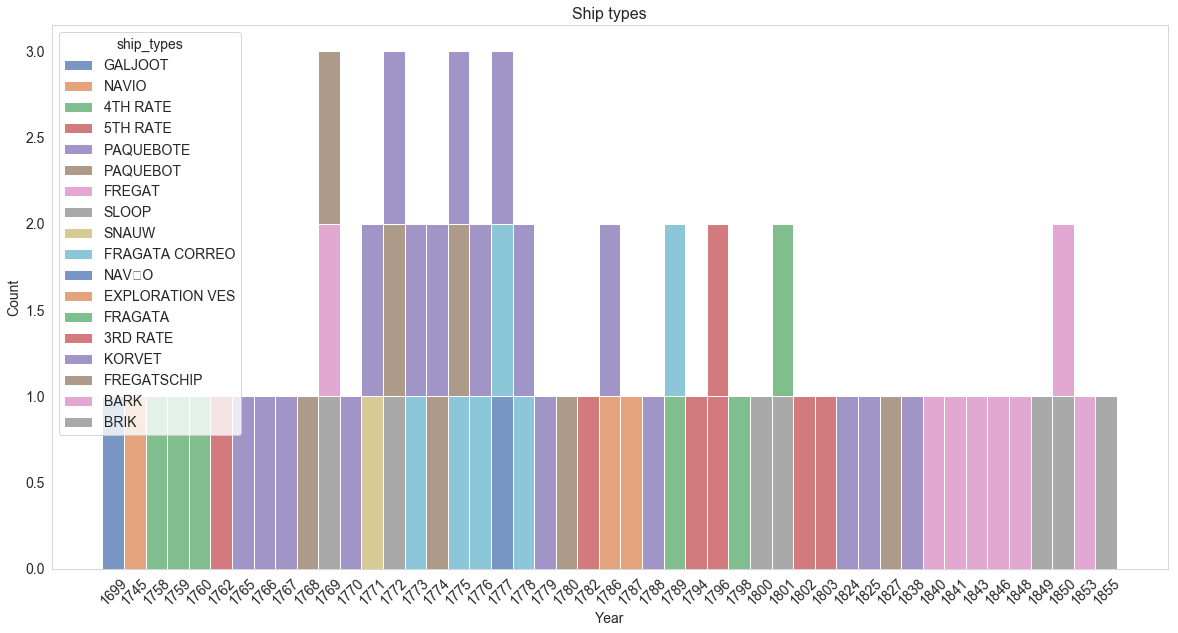

In [14]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)

g = sns.histplot(data=df_ships, x="Year", hue="ship_types", 
                 multiple="stack", palette='deep', ax=ax, legend=True)
ax.grid(False)
plt.setp(g.get_xticklabels(), rotation=45)
plt.title('Ship types', fontsize=16)

plt.show()


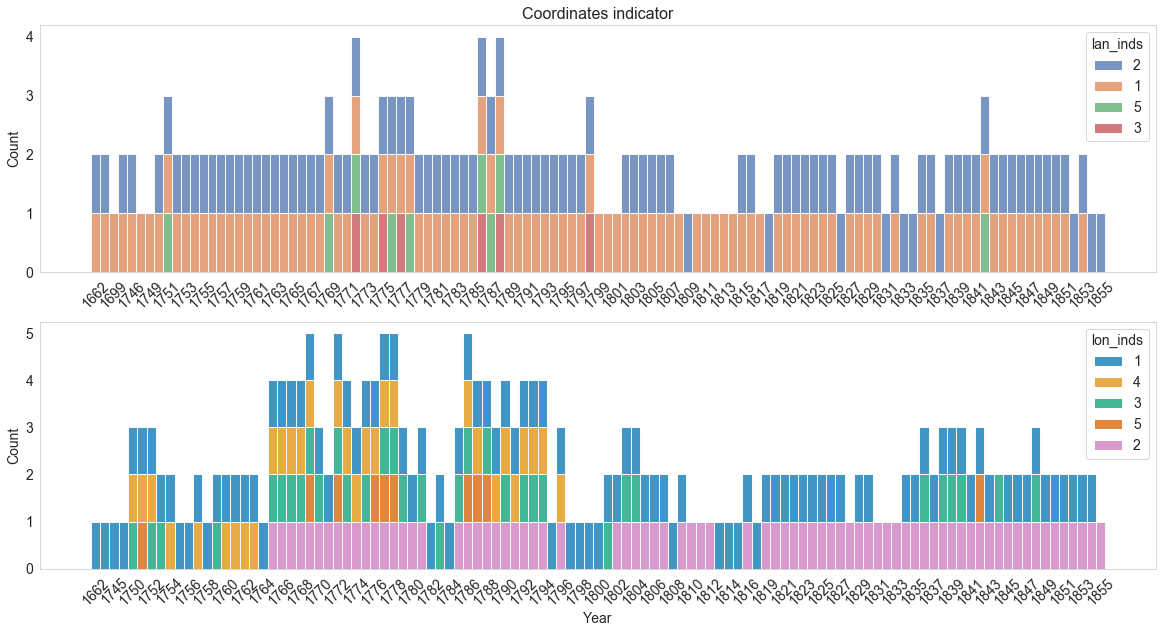

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))


g = sns.histplot(data=df_lati, x="Year", hue="lan_inds", 
                 multiple="stack", palette='deep', ax=ax[0], legend=True)
plt.setp(g.get_xticklabels(), rotation=45)
ax[0].grid(False)

xticks=ax[0].xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
        
ax[0].set_title('Coordinates indicator', fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax[0].set_xlabel('')
        

p = sns.histplot(data=df_loni, x="Year", hue="lon_inds", 
                 multiple="stack", palette='colorblind', ax=ax[1], legend=True)
plt.setp(p.get_xticklabels(), rotation=45)
ax[1].grid(False)

xticks=ax[1].xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
         
plt.show()

Code table for lat and lon indicators, according to this [information](https://stvno.github.io/page/cliwoc/):

```
{
	"1":"originates from dead reckoning",
	"2":"originates from true navigation (bearing/distance, celestial)",
	"3":"Interpolated manually",
	"4":"Interpolated",
	"5":"Inserted actual position (ports, islands, etc.)",
	"6":"Missing"
}
```

Is it worth using the coordinates from the supplemental metadata or should I use the imma.core lat and lon?

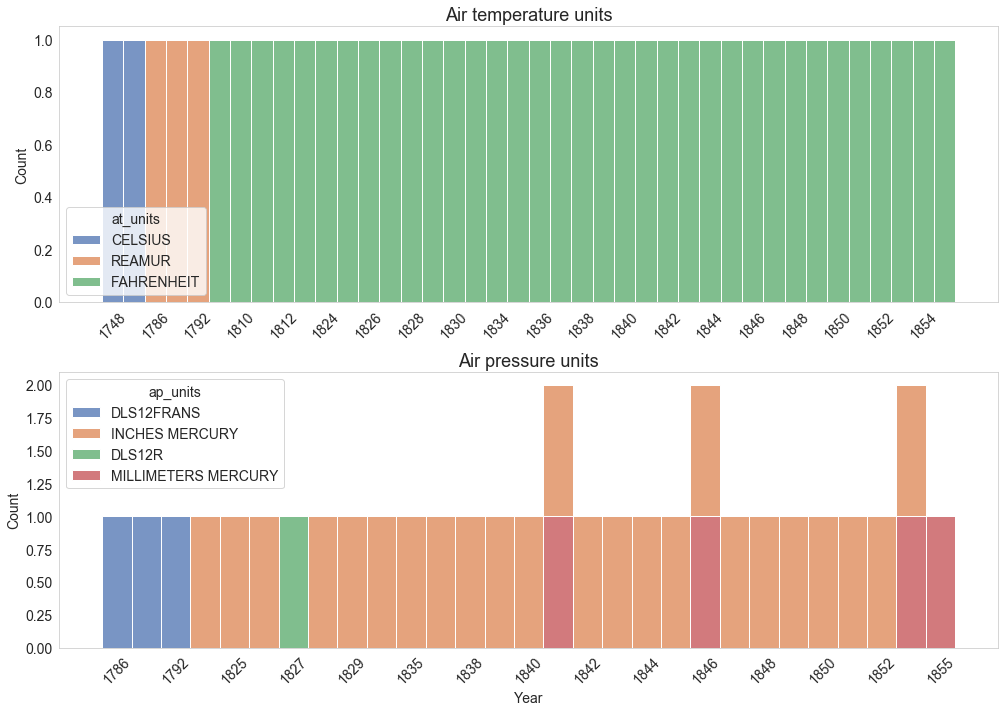

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(14,10))


g = sns.histplot(data=df_atu, x="Year", hue="at_units", 
                 multiple="stack", palette='deep', ax=ax[0], legend=True)
plt.setp(g.get_xticklabels(), rotation=45)
ax[0].grid(False)

ax[0].set_title('Air temperature units', fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax[0].set_xlabel('')

xticks=ax[0].xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)

p = sns.histplot(data=df_apu, x="Year", hue="ap_units", 
                 multiple="stack", palette='deep', ax=ax[1], legend=True)
plt.setp(p.get_xticklabels(), rotation=45)
ax[1].grid(False)

xticks=ax[1].xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
         
ax[1].set_title('Air pressure units', fontdict={'fontsize': 18, 'fontweight': 'medium'})

plt.tight_layout()

plt.show()

**It looks like we could be able to infer the barometer type from the Air pressure units code table.**

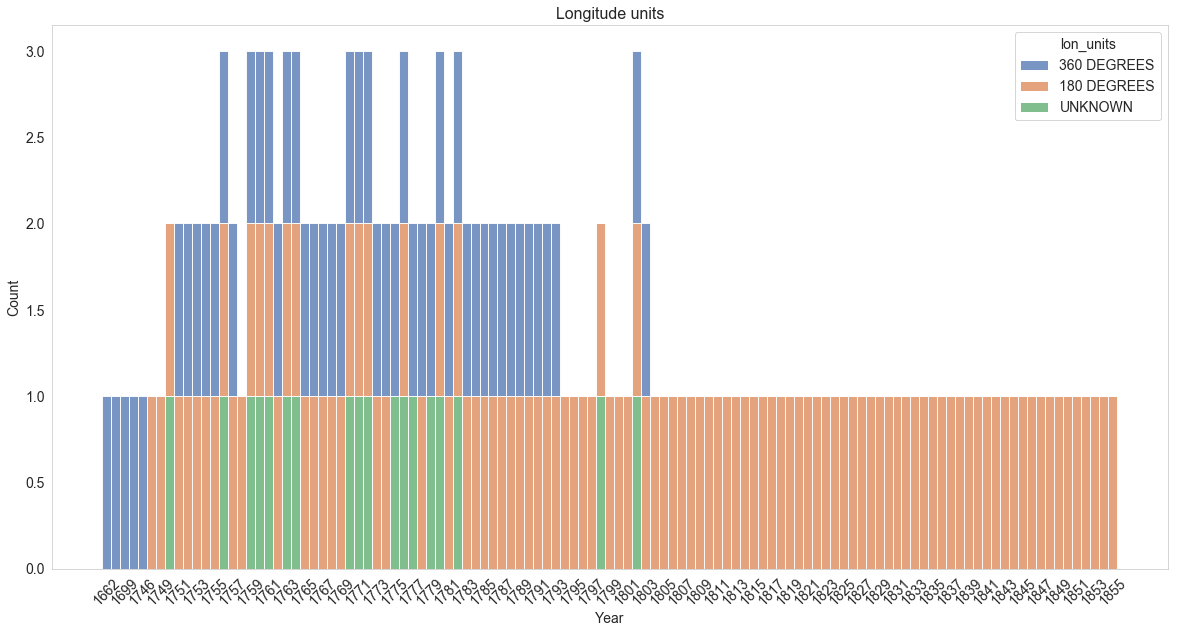

In [17]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)

g = sns.histplot(data=df_lonu, x="Year", hue="lon_units", 
                 multiple="stack", palette='deep', ax=ax, legend=True)
ax.grid(False)
plt.setp(g.get_xticklabels(), rotation=45)
plt.title('Longitude units', fontsize=16)

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)

plt.show()